# TFG

12/5/2025

## Case Study: Solar Forecasting
1. Naive
2. Prophet
3. XGB
4. GRU
5. LSTM

Using X1...X24 and (W+1...W+24)B

## Libraries

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from datetime import timedelta

# models
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GRU, Dense, InputLayer
from feature_engine.timeseries.forecasting import WindowFeatures
from skforecast.preprocessing import RollingFeatures
from skforecast.recursive import ForecasterEquivalentDate, ForecasterRecursive
from sktime.forecasting.naive import NaiveForecaster
from skforecast.model_selection import TimeSeriesFold, backtesting_forecaster


# functions
from utils.preprocess import *
from models.cnn_gru_model import build_cnn_gru_model, fit_cnn_gru_model, build_lstm
from models.prophet_model import train_prophet, forecast_prophet
from utils.evaluation import evaluate, evaluate_plot


c:\Users\melan\Documents\U\Clases\Cuarto\TFG\tfg-final\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## Load Data

In [2]:
df = pd.read_csv('data/final_unified_dataset.csv')
df_wind = preprocess_wind(df)
target='wind'

In [3]:
lag_features = [col for col in df_wind.columns if 'solar_power_' in col]
time_features = ['year', 'month', 'hour', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']
weather_features = [col for col in df_wind.columns if col not in lag_features + time_features + ['region', 'region_code', 'solar']]
weather_features

['wind',
 'temperature_2m',
 'relative_humidity_2m',
 'apparent_temperature',
 'precipitation',
 'surface_pressure',
 'cloud_cover',
 'wind_speed_10m',
 'wind_direction_10m',
 'wind_gusts_10m',
 'is_day',
 'sunshine_duration',
 'wind_power_t-24',
 'wind_power_t-168',
 'wind_speed_gusts',
 'total_radiation']

In [4]:
chosen_regions = ['Grand-Est', 'PACA']
regions = df_wind['region'].unique()
print(regions)

region_dfs = {}

for region in regions:
    region_data = df_wind[df_wind['region'] == region]
    train, val, test = split_data_val(region_data)
    energy_train, weather_train = divide_energy_weather(train, 'wind')
    energy_val, weather_val = divide_energy_weather(val, 'wind')
    energy_test, weather_test = divide_energy_weather(test, 'wind')
    region_data = region_data.drop(columns=['region'])
    region_dfs[region] = {
        'region_data': region_data.asfreq('h'),
        'train-test': (train, test),
        'energy_train': energy_train.asfreq('h'),
        'weather_train': weather_train.asfreq('h'),
        'energy_val': energy_val.asfreq('h'),
        'weather_val': weather_val.asfreq('h'),
        'energy_test': energy_test.asfreq('h'),
        'weather_test': weather_test.asfreq('h')
    }

['Auvergne-Rhône-Alpes' 'Bourgogne-Franche-Comté' 'Pays-de-la-Loire'
 'Bretagne' 'Centre-Val de Loire' 'Grand-Est' 'Hauts-de-France'
 'Ile-de-France' 'Normandie' 'Nouvelle-Aquitaine' 'Occitanie' 'PACA']
Train shape: (30648, 21), train period: 2018-01-01 00:00:00 to 2021-06-30 23:00:00
Validation shape: (4416, 21), validation period: 2021-07-01 00:00:00 to 2021-12-31 23:00:00
Test shape: (8760, 21), test period: 2022-01-01 00:00:00 to 2022-12-31 23:00:00
Train shape: (30648, 21), train period: 2018-01-01 00:00:00 to 2021-06-30 23:00:00
Validation shape: (4416, 21), validation period: 2021-07-01 00:00:00 to 2021-12-31 23:00:00
Test shape: (8760, 21), test period: 2022-01-01 00:00:00 to 2022-12-31 23:00:00
Train shape: (30648, 21), train period: 2018-01-01 00:00:00 to 2021-06-30 23:00:00
Validation shape: (4416, 21), validation period: 2021-07-01 00:00:00 to 2021-12-31 23:00:00
Test shape: (8760, 21), test period: 2022-01-01 00:00:00 to 2022-12-31 23:00:00
Train shape: (30648, 21), train 

In [5]:
weather_train

,wind_speed_10m,cloud_cover,total_radiation,is_day,wind_speed_gusts,surface_pressure
datetime,,,,,,
2018-01-01 00:00:00,8.42,79.0,0.0,0,204.8586,949.46
2018-01-01 01:00:00,9.09,98.3,0.0,0,235.6128,949.19
2018-01-01 02:00:00,14.50,93.8,0.0,0,550.7100,949.60
2018-01-01 03:00:00,13.77,95.6,0.0,0,541.2987,949.74
2018-01-01 04:00:00,13.30,86.7,0.0,0,500.3460,949.53
...,...,...,...,...,...,...
2021-06-30 19:00:00,14.05,0.3,78.6,1,583.6370,950.73
2021-06-30 20:00:00,12.87,0.1,2.8,0,465.2505,951.00
2021-06-30 21:00:00,12.22,0.1,0.0,0,408.2702,951.30


## Modeling
### Naive

In [6]:
naive_results = {}
for region, region_data in region_dfs.items():
    print(f'Naive forecast for {region}')
    y_true = region_data['energy_test'][24:].copy()
    y_pred_naive = region_data['energy_test'].shift(24).dropna()

    eval_naive = evaluate(y_true, y_pred_naive, 'Naive')

    naive_results[region] = {
        'y_true': y_true,
        'y_pred_naive': y_pred_naive,
        'mae': eval_naive['MAE'],
        'rmse': eval_naive['RMSE'],
        'nrmse': eval_naive['NRMSE']
    }
    #evaluate_plot(y_true, y_pred_naive, 'Naive', region, 'wind')


Naive forecast for Auvergne-Rhône-Alpes
Naive	MAE: 104.98758012820512, RMSE: 138.553091289939, NRMSE: 0.843290845171321
Naive forecast for Bourgogne-Franche-Comté
Naive	MAE: 165.04412774725276, RMSE: 227.06787285223595, NRMSE: 0.9902102566655843
Naive forecast for Pays-de-la-Loire
Naive	MAE: 213.32234432234432, RMSE: 306.53683631325845, NRMSE: 0.9266419456679524
Naive forecast for Bretagne
Naive	MAE: 160.59151785714286, RMSE: 234.26188644095228, NRMSE: 1.0113647983573926
Naive forecast for Centre-Val de Loire
Naive	MAE: 227.40230082417582, RMSE: 321.40349809995575, NRMSE: 1.0012136238438702
Naive forecast for Grand-Est
Naive	MAE: 695.0968406593406, RMSE: 979.8406043573334, NRMSE: 1.0406674753422596
Naive forecast for Hauts-de-France
Naive	MAE: 853.57326007326, RMSE: 1226.9006379587283, NRMSE: 0.994332881081048
Naive forecast for Ile-de-France
Naive	MAE: 27.69471153846154, RMSE: 38.479850436975646, NRMSE: 1.0455775339454079
Naive forecast for Normandie
Naive	MAE: 139.53851877289378, RMS

### Prophet

In [7]:
# # Prophet without exogenous variables
# for region, region_data in region_dfs.items():
#     print(f"Prophet forecast for {region}")
#     train_data, test_data = region_data['train-test']
#     train_df = train_data.reset_index().rename(columns={'datetime': 'ds', 'wind':'y'})
#     prophet_noX = Prophet(daily_seasonality=True, yearly_seasonality=True)
#     prophet_noX.fit(train_df)

#     future= prophet_noX.make_future_dataframe(periods=365)
#     forecast = prophet_noX.predict(future)

#     forecast = forecast[forecast['ds'] > train_df['ds'].max()]

#     fig = prophet_noX.plot(forecast)
#     plt.title(f'{region} Wind Energy Forecast - Prophet\n(without exogenous variables)')

In [8]:
# Prophet with exogenous variables

prophet_results = {}
for region, region_data in region_dfs.items():
    print(f"Prophet X for {region}")
    energy_train = region_data['energy_train']
    weather_train = region_data['weather_train']
    energy_test = region_data['energy_test']
    weather_test = region_data['weather_test']

    shifted_weather_train = weather_train.shift(-24).dropna() # W+1
    # add noise to weather data
    shifted_weather_train = add_weather_error(shifted_weather_train)
    max_idx = shifted_weather_train.index.max()
    energy_train = energy_train.loc[:max_idx]

    shifted_weather_test = weather_test.shift(-24).dropna() # W+1
    # add noise to weather test
    shifted_weather_test = add_weather_error(shifted_weather_test)
    max_idx = shifted_weather_test.index.max()
    energy_test = energy_test.shift(-24).dropna() # E+1

    prophet_df = pd.concat([energy_train, shifted_weather_train], axis=1)
    prophet_test_df = pd.concat([energy_test, shifted_weather_test], axis=1)
    prophet_model = train_prophet(prophet_df, 'wind') 
    #y_pred_prophet = forecast_prophet(prophet_model, prophet_test_df, 'wind', region)
    
    predictions = []

    for day in pd.date_range(start='2022-01-01', end='2022-12-30', freq='D'):
        # Define 24h future window
        future_window = pd.date_range(start=day, periods=24, freq='h')
        
        df_future = pd.DataFrame({'ds': future_window})
        
        df_future = df_future.set_index('ds').join(weather_test).reset_index()
        
        forecast = prophet_model.predict(df_future)
        pred = np.maximum(forecast['yhat'].values, 0) # set negatives to 0 

        predictions.append(pred)
    
    y_pred_prophet = np.stack(predictions).flatten()

    eval_prophet = evaluate(energy_test, y_pred_prophet, 'Prophet')
    #evaluate_plot(y_true, y_pred_prophet, 'prophet', region, 'wind')

    prophet_results[region] = {
        'y_true': energy_test,
        'y_pred_prophet': y_pred_prophet,
        'mae': eval_prophet['MAE'], 
        'rmse': eval_prophet['RMSE'],
        'nrmse': eval_prophet['NRMSE']
    }

Prophet X for Auvergne-Rhône-Alpes


18:27:13 - cmdstanpy - INFO - Chain [1] start processing
18:27:19 - cmdstanpy - INFO - Chain [1] done processing


Prophet	MAE: 102.01099496658279, RMSE: 121.31036683645668, NRMSE: 0.7383445639872709
Prophet X for Bourgogne-Franche-Comté


18:27:28 - cmdstanpy - INFO - Chain [1] start processing
18:27:35 - cmdstanpy - INFO - Chain [1] done processing


Prophet	MAE: 165.26545768701973, RMSE: 199.48328398737948, NRMSE: 0.8699178415529495
Prophet X for Pays-de-la-Loire


18:27:44 - cmdstanpy - INFO - Chain [1] start processing
18:27:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet	MAE: 210.35359061014123, RMSE: 290.52912590637436, NRMSE: 0.8782516246366311
Prophet X for Bretagne


18:28:03 - cmdstanpy - INFO - Chain [1] start processing
18:28:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet	MAE: 156.09791299388687, RMSE: 200.99389391767264, NRMSE: 0.8677388886491023
Prophet X for Centre-Val de Loire


18:28:19 - cmdstanpy - INFO - Chain [1] start processing
18:28:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet	MAE: 231.2271709707365, RMSE: 287.4400545448825, NRMSE: 0.8954130877544458
Prophet X for Grand-Est


18:28:41 - cmdstanpy - INFO - Chain [1] start processing
18:28:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet	MAE: 657.2182577715405, RMSE: 847.2107632913545, NRMSE: 0.8998041948827754
Prophet X for Hauts-de-France


18:28:57 - cmdstanpy - INFO - Chain [1] start processing
18:29:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet	MAE: 828.099924941102, RMSE: 1065.1860080942613, NRMSE: 0.8632724114299597
Prophet X for Ile-de-France


18:29:14 - cmdstanpy - INFO - Chain [1] start processing
18:29:21 - cmdstanpy - INFO - Chain [1] done processing


Prophet	MAE: 26.648953643209182, RMSE: 33.898094737251135, NRMSE: 0.9210817063562508
Prophet X for Normandie


18:29:31 - cmdstanpy - INFO - Chain [1] start processing
18:29:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet	MAE: 136.8777674252687, RMSE: 177.31411979542082, NRMSE: 0.8460865766037905
Prophet X for Nouvelle-Aquitaine


18:29:49 - cmdstanpy - INFO - Chain [1] start processing
18:29:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet	MAE: 217.3976371197137, RMSE: 267.94040698461765, NRMSE: 0.8000114138516593
Prophet X for Occitanie


18:30:07 - cmdstanpy - INFO - Chain [1] start processing
18:30:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet	MAE: 240.7276364144198, RMSE: 290.8530634078756, NRMSE: 0.8145234177168116
Prophet X for PACA


18:30:24 - cmdstanpy - INFO - Chain [1] start processing
18:30:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet	MAE: 19.142292345085743, RMSE: 21.935122418607175, NRMSE: 1.0816353881264504


### XGBoost

In [9]:
xgboost_results = {}

for region, region_data in region_dfs.items():
    print(f"Forecasting for {region}")
    energy_train = region_data['energy_train']
    weather_train = region_data['weather_train']
    energy_test = region_data['energy_test']
    weather_test = region_data['weather_test']

    weather_train = add_weather_error(weather_train)
    weather_test = add_weather_error(weather_test)

    X_energy_train, X_weather_train, y_train = create_daily_blocks(energy_train, weather_train)
    X_energy_test, X_weather_test, y_test = create_daily_blocks(energy_test, weather_test)

    X_weather_flat = X_weather_train.reshape(X_weather_train.shape[0], -1)
    X_weather_flat_test = X_weather_test.reshape(X_weather_test.shape[0], -1)

    X_train = np.hstack([X_energy_train, X_weather_flat])
    X_test = np.hstack([X_energy_test, X_weather_flat_test])

    xgb_model = XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.05,
        random_state=42
    )

    multi_output_model = MultiOutputRegressor(xgb_model)
    multi_output_model.fit(X_train, y_train)

    y_pred_xgb = multi_output_model.predict(X_test).flatten() # (364, 24)
    y_pred_xgb = np.maximum(y_pred_xgb, 0) # set negatives to zero


    y_true = pd.Series(y_test.flatten(), index= energy_test.index[24:])

    eval_xgb = evaluate(y_true, y_pred_xgb, 'XGB')
    # evaluate_plot(y_true, y_pred_xgb, 'XGB', region, 'wind')

    xgboost_results[region] = {
        'y_true': y_true,
        'y_pred_xgb': y_pred_xgb,
        'mae': eval_xgb['MAE'],
        'rmse': eval_xgb['RMSE'],
        'nrmse': eval_xgb['NRMSE']
    }



Forecasting for Auvergne-Rhône-Alpes
XGB	MAE: 46.48269580053541, RMSE: 64.3595206112202, NRMSE: 0.391718394918252
Forecasting for Bourgogne-Franche-Comté
XGB	MAE: 63.9782962787064, RMSE: 93.56704378510362, NRMSE: 0.40803238819337484
Forecasting for Pays-de-la-Loire
XGB	MAE: 117.31089394591449, RMSE: 193.30461487076468, NRMSE: 0.5843479256352332
Forecasting for Bretagne
XGB	MAE: 46.757572507574444, RMSE: 67.63609433707516, NRMSE: 0.2920012553050947
Forecasting for Centre-Val de Loire
XGB	MAE: 80.88324229965062, RMSE: 117.78940176640194, NRMSE: 0.3669292788974691
Forecasting for Grand-Est
XGB	MAE: 240.32167239547212, RMSE: 356.0130155474506, NRMSE: 0.3781137099556627
Forecasting for Hauts-de-France
XGB	MAE: 309.1028086222135, RMSE: 465.2749892880479, NRMSE: 0.3770788002551361
Forecasting for Ile-de-France
XGB	MAE: 15.226835368895363, RMSE: 22.619668179226064, NRMSE: 0.6146234095227279
Forecasting for Normandie
XGB	MAE: 47.515365236735605, RMSE: 69.77595541278262, NRMSE: 0.332948663719360

### CNN-GRU

Forecasting for Auvergne-Rhône-Alpes
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2188 - mse: 0.0839 - val_loss: 0.1307 - val_mse: 0.0344
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1380 - mse: 0.0372 - val_loss: 0.1254 - val_mse: 0.0304
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1165 - mse: 0.0271 - val_loss: 0.1119 - val_mse: 0.0250
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1038 - mse: 0.0213 - val_loss: 0.0943 - val_mse: 0.0173
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0991 - mse: 0.0188 - val_loss: 0.1054 - val_mse: 0.0217
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0971 - mse: 0.0180 - val_loss: 0.0907 - val_mse: 0.0157
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0952 - mse: 0.0173 - val_loss: 0.0882 - val_mse: 0.0140
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0920 - mse: 0.0158 - val_loss: 0.0902 - val_mse: 0.0156
Epoch 9/50
40/40 ━━━━━━━━━━

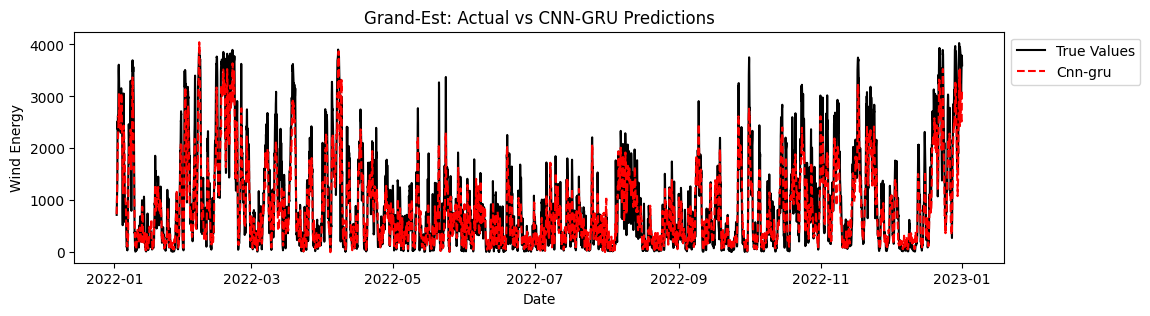

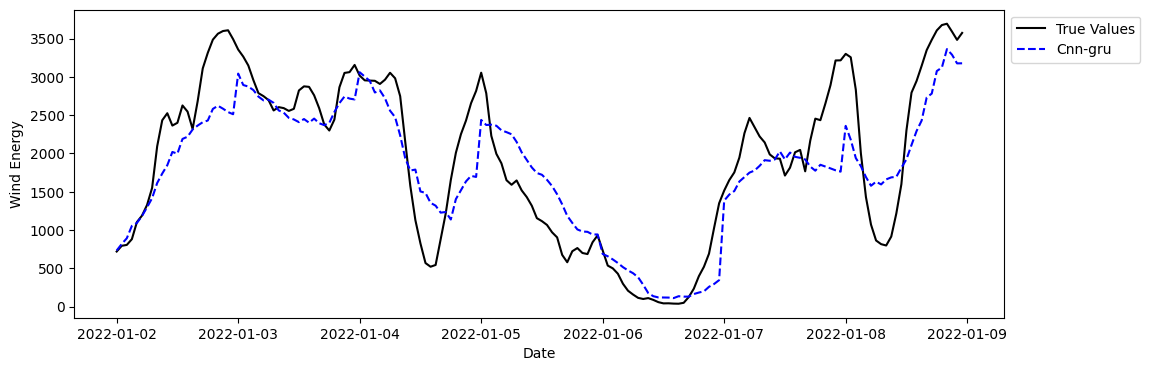

Forecasting for Hauts-de-France
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1761 - mse: 0.0649 - val_loss: 0.1168 - val_mse: 0.0332
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1188 - mse: 0.0338 - val_loss: 0.0990 - val_mse: 0.0231
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1005 - mse: 0.0229 - val_loss: 0.1007 - val_mse: 0.0233
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0938 - mse: 0.0193 - val_loss: 0.0928 - val_mse: 0.0194
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0854 - mse: 0.0164 - val_loss: 0.0857 - val_mse: 0.0161
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0882 - mse: 0.0170 - val_loss: 0.0860 - val_mse: 0.0161
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0790 - mse: 0.0135 - val_loss: 0.0796 - val_mse: 0.0143
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0778 - mse: 0.0127 - val_loss: 0.0769 - val_mse: 0.0128
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━

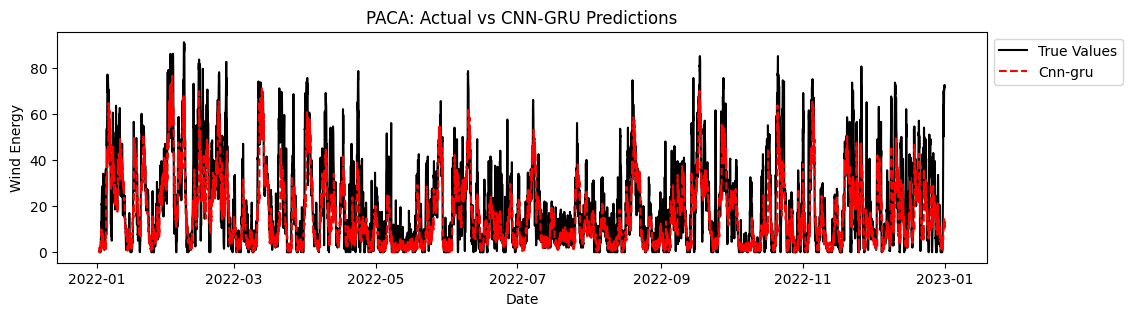

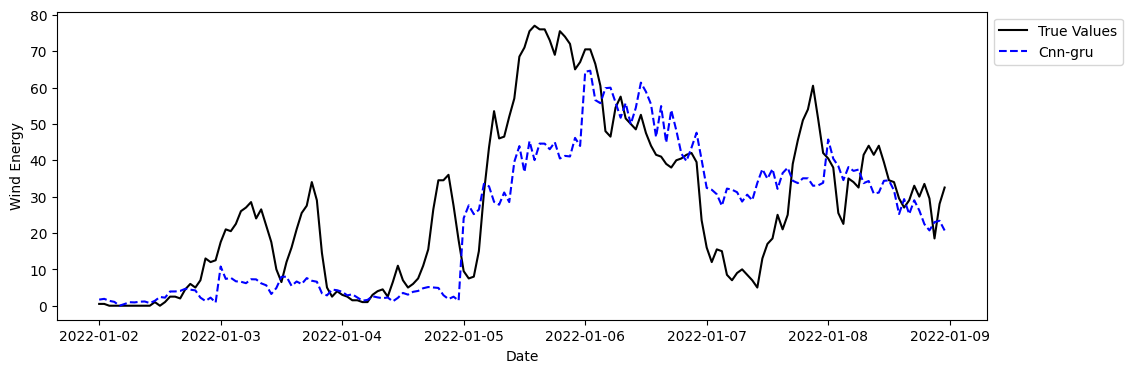

In [11]:
cnn_gru_results = {}
input_width = 24
forecast_horizon=24

for region, region_data in region_dfs.items():
    print(f"Forecasting for {region}")
    energy_train = region_data['energy_train']
    weather_train = region_data['weather_train']
    energy_val = region_data['energy_val']
    weather_val = region_data['weather_val']
    energy_test = region_data['energy_test']
    weather_test = region_data['weather_test']

    # add 1% of error to future weather data
    weather_train = add_weather_error(weather_train)
    weather_val = add_weather_error(weather_val)
    weather_test = add_weather_error(weather_test)

    # create sequences
    X_energy_train, X_weather_train, y_train = create_daily_blocks(energy_train, weather_train)
    X_energy_val, X_weather_val, y_val = create_daily_blocks(energy_val, weather_val)
    X_energy_test, X_weather_test, y_test = create_daily_blocks(energy_test, weather_test)

    # reshape energy to 3D (N, 24, 1)
    X_energy_train_3D = X_energy_train[..., np.newaxis]  # shape (N, 24, 1)
    X_energy_val_3D = X_energy_val[..., np.newaxis]
    X_energy_test_3D  = X_energy_test[..., np.newaxis]

    # join energy and weather
    X_train_combined = np.concatenate([X_energy_train_3D, X_weather_train], axis=-1)
    X_val_combined = np.concatenate([X_energy_val_3D, X_weather_val], axis=-1)
    X_test_combined  = np.concatenate([X_energy_test_3D, X_weather_test], axis=-1)

    # flatten to scale (shapes not matching)
    X_train_flat = X_train_combined.reshape(-1, X_train_combined.shape[-1])
    X_val_flat = X_val_combined.reshape(-1, X_val_combined.shape[-1])
    X_test_flat  = X_test_combined.reshape(-1, X_test_combined.shape[-1])

    # scale the data
    scaler_X = MinMaxScaler()
    X_train_scaled_flat = scaler_X.fit_transform(X_train_flat)
    X_val_scaled_flat = scaler_X.transform(X_val_flat)
    X_test_scaled_flat  = scaler_X.transform(X_test_flat)

    # Reshape back to original 
    X_train_scaled = X_train_scaled_flat.reshape(X_train_combined.shape)
    X_val_scaled = X_val_scaled_flat.reshape(X_val_combined.shape)
    X_test_scaled  = X_test_scaled_flat.reshape(X_test_combined.shape)

    scaler_y = MinMaxScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(y_train.shape)
    y_val_scaled = scaler_y.transform(y_val.reshape(-1,1)).reshape(y_val.shape)
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

    # fit cnn gru model
    input_shape = X_train_scaled.shape[1:]
    cnn_gru_model = build_cnn_gru_model(input_shape, forecast_horizon)
    history = fit_cnn_gru_model(cnn_gru_model, 
                                X_train_scaled, y_train_scaled,
                                X_val_scaled, y_val_scaled)
    # predict
    y_pred_cnn_gru = cnn_gru_model.predict(X_test_scaled)
    y_pred_cnn_gru = scaler_y.inverse_transform(y_pred_cnn_gru).flatten()
    y_pred_cnn_gru = np.maximum(y_pred_cnn_gru, 0) # set negatives to 0

    y_true = pd.Series(y_test.flatten(), index=energy_test.index[24:])

    eval_cnn_gru = evaluate(y_true, y_pred_cnn_gru, 'CNN GRU')
    if region in chosen_regions:
        evaluate_plot(y_true, y_pred_cnn_gru, 'CNN-GRU', region, 'wind')

    cnn_gru_results[region] = {
        'y_true': y_true,
        'y_pred_cnn_gru': y_pred_cnn_gru,
        'mae': eval_cnn_gru['MAE'],
        'rmse': eval_cnn_gru['RMSE'],
        'nrmse': eval_cnn_gru['NRMSE']
    }

    # # Plot loss and val loss
    # plt.figure(figsize=(6, 3))
    # plt.plot(history.history['loss'], label='Train Loss', color='blue')
    # plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    # plt.xlabel('Epochs')
    # plt.title(f'{region} - CNN-GRU Model Loss')
    # plt.legend()
    # plt.show()




### LSTM

Forecasting for Auvergne-Rhône-Alpes
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.1793 - mse: 0.0580 - val_loss: 0.1092 - val_mse: 0.0223
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0985 - mse: 0.0173 - val_loss: 0.1184 - val_mse: 0.0275
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0894 - mse: 0.0149 - val_loss: 0.0952 - val_mse: 0.0173
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0926 - mse: 0.0153 - val_loss: 0.1113 - val_mse: 0.0247
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0863 - mse: 0.0135 - val_loss: 0.0988 - val_mse: 0.0191
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0811 - mse: 0.0122 - val_loss: 0.0910 - val_mse: 0.0158
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0815 - mse: 0.0122 - val_loss: 0.0949 - val_mse: 0.0173
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0801 - mse: 0.0116 - val_loss: 0.1076 - val_mse: 0.0212
Epoch 9/50
40/40 ━━━━━━━━━━

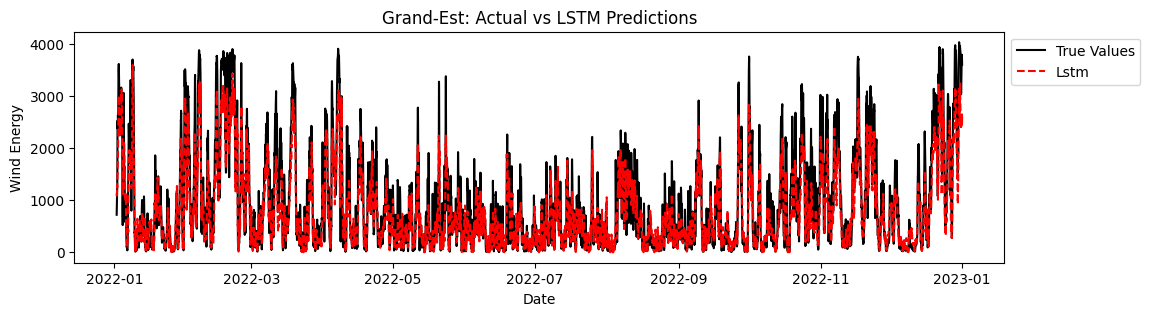

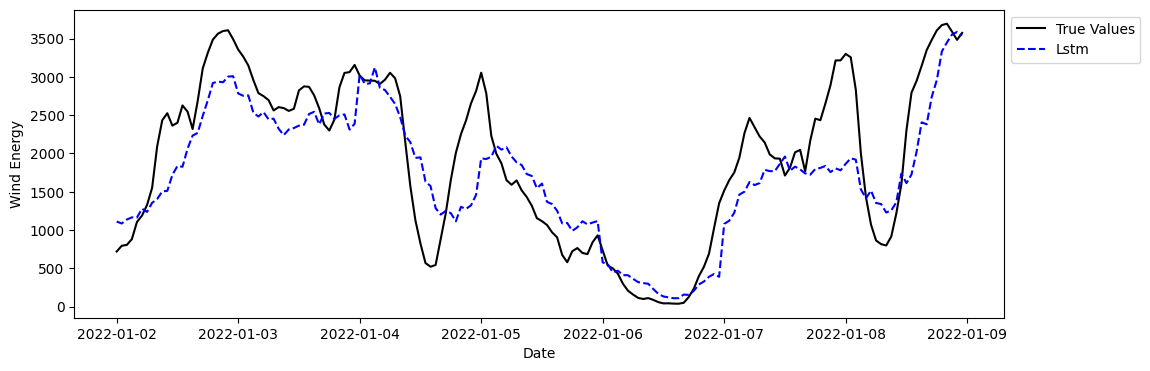

Forecasting for Hauts-de-France
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.1645 - mse: 0.0540 - val_loss: 0.1045 - val_mse: 0.0232
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0842 - mse: 0.0143 - val_loss: 0.0894 - val_mse: 0.0174
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0749 - mse: 0.0120 - val_loss: 0.0776 - val_mse: 0.0126
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0645 - mse: 0.0086 - val_loss: 0.0731 - val_mse: 0.0118
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0631 - mse: 0.0080 - val_loss: 0.0677 - val_mse: 0.0099
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0587 - mse: 0.0071 - val_loss: 0.0634 - val_mse: 0.0088
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0567 - mse: 0.0066 - val_loss: 0.0739 - val_mse: 0.0123
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0565 - mse: 0.0068 - val_loss: 0.0686 - val_mse: 0.0101
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━

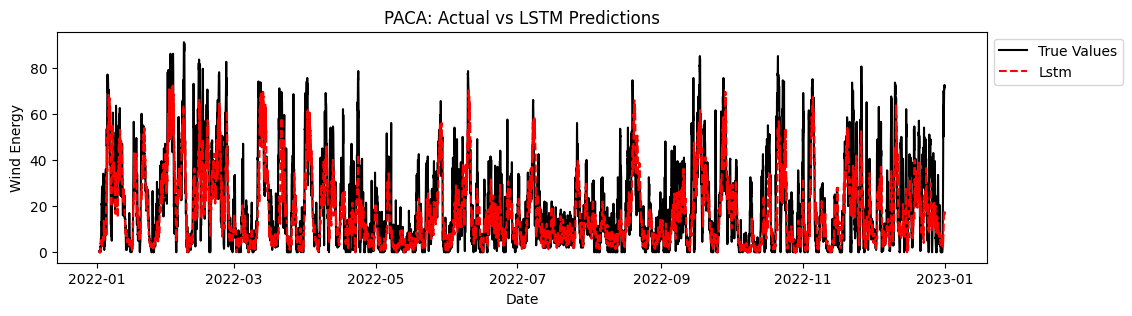

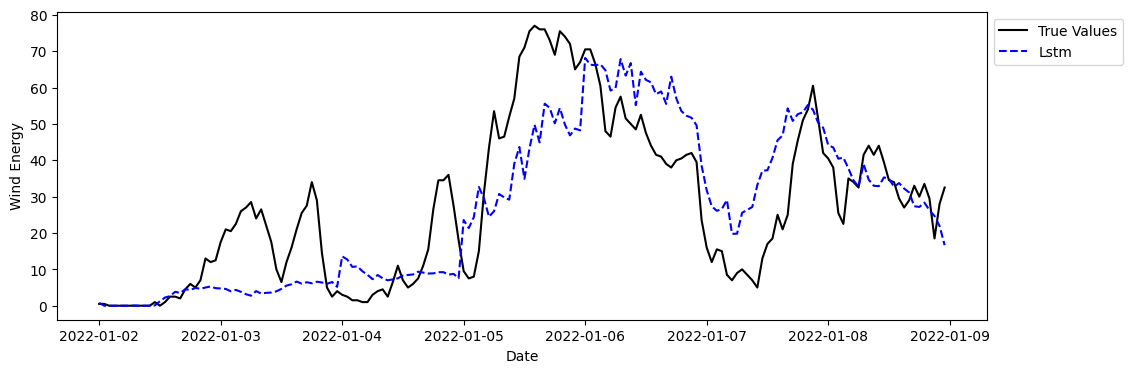

In [12]:
lstm_results = {}
input_width = 24
forecast_horizon=24


for region, region_data in region_dfs.items():
    print(f"Forecasting for {region}")
    energy_train = region_data['energy_train']
    weather_train = region_data['weather_train']
    energy_val = region_data['energy_val']
    weather_val = region_data['weather_val']
    energy_test = region_data['energy_test']
    weather_test = region_data['weather_test']

    # add 1% of error to future weather data
    weather_train = add_weather_error(weather_train)
    weather_val = add_weather_error(weather_val)
    weather_test = add_weather_error(weather_test)

    # create sequences
    X_energy_train, X_weather_train, y_train = create_daily_blocks(energy_train, weather_train)
    X_energy_val, X_weather_val, y_val = create_daily_blocks(energy_val, weather_val)
    X_energy_test, X_weather_test, y_test = create_daily_blocks(energy_test, weather_test)

    # reshape energy to 3D (N, 24, 1)
    X_energy_train_3D = X_energy_train[..., np.newaxis]  # shape (N, 24, 1)
    X_energy_val_3D = X_energy_val[..., np.newaxis]
    X_energy_test_3D  = X_energy_test[..., np.newaxis]

    # join energy and weather
    X_train_combined = np.concatenate([X_energy_train_3D, X_weather_train], axis=-1)
    X_val_combined = np.concatenate([X_energy_val_3D, X_weather_val], axis=-1)
    X_test_combined  = np.concatenate([X_energy_test_3D, X_weather_test], axis=-1)

    # flatten to scale (shapes not matching)
    X_train_flat = X_train_combined.reshape(-1, X_train_combined.shape[-1])
    X_val_flat = X_val_combined.reshape(-1, X_val_combined.shape[-1])
    X_test_flat  = X_test_combined.reshape(-1, X_test_combined.shape[-1])

    # scale the data
    scaler_X = MinMaxScaler()
    X_train_scaled_flat = scaler_X.fit_transform(X_train_flat)
    X_val_scaled_flat = scaler_X.transform(X_val_flat)
    X_test_scaled_flat  = scaler_X.transform(X_test_flat)

    # Reshape back to original 
    X_train_scaled = X_train_scaled_flat.reshape(X_train_combined.shape)
    X_val_scaled = X_val_scaled_flat.reshape(X_val_combined.shape)
    X_test_scaled  = X_test_scaled_flat.reshape(X_test_combined.shape)

    scaler_y = MinMaxScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(y_train.shape)
    y_val_scaled = scaler_y.transform(y_val.reshape(-1,1)).reshape(y_val.shape)
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

    # fit cnn gru model
    input_shape = X_train_scaled.shape[1:]
    lstm_model = build_lstm(input_shape, forecast_horizon)
    history = fit_cnn_gru_model(lstm_model, 
                                X_train_scaled, y_train_scaled,
                                X_val_scaled, y_val_scaled)
    # predict
    y_pred_lstm= lstm_model.predict(X_test_scaled)
    y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm).flatten()
    y_pred_lstm = np.maximum(y_pred_lstm, 0) # set negatives to 0

    y_true = pd.Series(y_test.flatten(), index=energy_test.index[24:])

    eval_lstm = evaluate(y_true, y_pred_lstm, 'LSTM')
    if region in chosen_regions:
        evaluate_plot(y_true, y_pred_lstm, 'LSTM', region, 'wind')

    lstm_results[region] = {
        'y_true': y_true,
        'y_pred_lstm': y_pred_lstm,
        'mae': eval_lstm['MAE'],
        'rmse': eval_lstm['RMSE'],
        'nrmse': eval_lstm['NRMSE']
    }

    # # Plot loss and val loss
    # plt.figure(figsize=(6, 3))
    # plt.plot(history.history['loss'], label='Train Loss', color='blue')
    # plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    # plt.xlabel('Epochs')
    # plt.title(f'{region} - LSTM Model Loss')
    # plt.legend()
    # plt.show()




## Results

In [13]:

all_results = {
    'Naive': naive_results,
    'Prophet': prophet_results,
    'XGB': xgboost_results,
    'CNN-GRU': cnn_gru_results, 
    'LSTM': lstm_results
}

records = []

for model_name, regions in all_results.items():
    for region_name, metrics in regions.items():
        record = {
            'Region': region_name,
            'Model': model_name, 
            'MAE': metrics['mae'],
            'RMSE': metrics['rmse'],
            'NRMSE': metrics['nrmse']
        }
        records.append(record)


df_results = pd.DataFrame(records)


In [14]:
df_results

,Region,Model,MAE,RMSE,NRMSE
0,Auvergne-Rhône-Alpes,Naive,104.987580,138.553091,0.843291
1,Bourgogne-Franche-Comté,Naive,165.044128,227.067873,0.990210
2,Pays-de-la-Loire,Naive,213.322344,306.536836,0.926642
3,Bretagne,Naive,160.591518,234.261886,1.011365
4,Centre-Val de Loire,Naive,227.402301,321.403498,1.001214
5,Grand-Est,Naive,695.096841,979.840604,1.040667
6,Hauts-de-France,Naive,853.573260,1226.900638,0.994333
7,Ile-de-France,Naive,27.694712,38.479850,1.045578
8,Normandie,Naive,139.538519,202.788474,0.967642
9,Nouvelle-Aquitaine,Naive,226.914206,312.193866,0.932143


In [15]:
df_results.to_csv('results/df_results_wind_all.csv')

In [16]:
df_pivot = df_results.pivot(index='Region', columns='Model', values=['MAE', 'RMSE', 'NRMSE'])
# Swap the column levels: make Model the first level, Metric the second
df_pivot.columns = df_pivot.columns.swaplevel(0, 1)

# # Optional: Sort columns so models are grouped together
df_pivot = df_pivot.sort_index(axis=1, level=0)
#print(df_pivot.to_latex(float_format="%.2f"))
df_pivot

Model                       CNN-GRU                              LSTM  \
                                MAE     NRMSE        RMSE         MAE   
Region                                                                  
Auvergne-Rhône-Alpes      49.329356  0.407796   67.001007   51.194454   
Bourgogne-Franche-Comté   67.239243  0.423098   97.021706   62.725040   
Bretagne                  60.074079  0.372999   86.397511   49.999978   
Centre-Val de Loire       85.524360  0.375898  120.668505   81.866882   
Grand-Est                246.033837  0.374139  352.270310  261.253559   
Hauts-de-France          324.772539  0.383124  472.733812  303.316084   
Ile-de-France             13.778783  0.539242   19.845434   14.931709   
Normandie                 46.683327  0.310144   64.996758   47.508512   
Nouvelle-Aquitaine       110.827240  0.477996  160.090791  133.639427   
Occitanie                 93.007924  0.357536  127.670176   92.920465   
PACA                       9.020684  0.658178   13.347580    8.883320   
Pays-de-la-Loire         104.883260  0.506776  167.643619  121.796817   

Model                                               Naive            \
                            NRMSE        RMSE         MAE     NRMSE   
Region                                                                
Auvergne-Rhône-Alpes     0.415853   68.324801  104.987580  0.843291   
Bourgogne-Franche-Comté  0.381466   87.474960  165.044128  0.990210   
Bretagne                 0.310176   71.845853  160.591518  1.011365   
Centre-Val de Loire      0.368132  118.175343  227.402301  1.001214   
Grand-Est                0.401105  377.660321  695.096841  1.040667   
Hauts-de-France          0.358506  442.358324  853.573260  0.994333   
Ile-de-France            0.580613   21.367999   27.694712  1.045578   
Normandie                0.321895   67.459378  139.538519  0.967642   
Nouvelle-Aquitaine       0.572647  191.791376  226.914206  0.932143   
Occitanie                0.361434  129.062376  247.824805  0.917633   
PACA                     0.634727   12.872002   16.923764  1.144914   
Pays-de-la-Loire         0.581420  192.336016  213.322344  0.926642   

Model                                    Prophet                         \
                                RMSE         MAE     NRMSE         RMSE   
Region                                                                    
Auvergne-Rhône-Alpes      138.553091  102.010995  0.738345   121.310367   
Bourgogne-Franche-Comté   227.067873  165.265458  0.869918   199.483284   
Bretagne                  234.261886  156.097913  0.867739   200.993894   
Centre-Val de Loire       321.403498  231.227171  0.895413   287.440055   
Grand-Est                 979.840604  657.218258  0.899804   847.210763   
Hauts-de-France          1226.900638  828.099925  0.863272  1065.186008   
Ile-de-France              38.479850   26.648954  0.921082    33.898095   
Normandie                 202.788474  136.877767  0.846087   177.314120   
Nouvelle-Aquitaine        312.193866  217.397637  0.800011   267.940407   
Occitanie                 327.671833  240.727636  0.814523   290.853063   
PACA                       23.218378   19.142292  1.081635    21.935122   
Pays-de-la-Loire          306.536836  210.353591  0.878252   290.529126   

Model                           XGB                        
                                MAE     NRMSE        RMSE  
Region                                                     
Auvergne-Rhône-Alpes      46.482696  0.391718   64.359521  
Bourgogne-Franche-Comté   63.978296  0.408032   93.567044  
Bretagne                  46.757573  0.292001   67.636094  
Centre-Val de Loire       80.883242  0.366929  117.789402  
Grand-Est                240.321672  0.378114  356.013016  
Hauts-de-France          309.102809  0.377079  465.274989  
Ile-de-France             15.226835  0.614623   22.619668  
Normandie                 47.515365  0.332949   69.775955  
Nouvelle-Aquitaine       114.620273  0.503159  168.5

In [17]:
# Step 2: Define custom model and metric order
model_order = ['Naive', 'Prophet', 'XGB', 'CNN-GRU', 'LSTM']
metric_order = ['MAE', 'RMSE', 'NRMSE']

# Step 3: Create sorted MultiIndex based on your custom order
ordered_columns = [(model, metric) for model in model_order for metric in metric_order if (model, metric) in df_pivot.columns]

# Step 4: Apply reordering
df_pivot = df_pivot[ordered_columns]
avg_row = df_pivot.mean(axis=0)

# Append the average as a new row at the bottom
df_pivot.loc['Average'] = avg_row
df_pivot

C:\Users\melan\AppData\Local\Temp\ipykernel_12488\1524181730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pivot.loc['Average'] = avg_row


Model                         Naive                            Prophet  \
                                MAE         RMSE     NRMSE         MAE   
Region                                                                   
Auvergne-Rhône-Alpes     104.987580   138.553091  0.843291  102.010995   
Bourgogne-Franche-Comté  165.044128   227.067873  0.990210  165.265458   
Bretagne                 160.591518   234.261886  1.011365  156.097913   
Centre-Val de Loire      227.402301   321.403498  1.001214  231.227171   
Grand-Est                695.096841   979.840604  1.040667  657.218258   
Hauts-de-France          853.573260  1226.900638  0.994333  828.099925   
Ile-de-France             27.694712    38.479850  1.045578   26.648954   
Normandie                139.538519   202.788474  0.967642  136.877767   
Nouvelle-Aquitaine       226.914206   312.193866  0.932143  217.397637   
Occitanie                247.824805   327.671833  0.917633  240.727636   
PACA                      16.923764    23.218378  1.144914   19.142292   
Pays-de-la-Loire         213.322344   306.536836  0.926642  210.353591   
Average                  256.576165   361.576402  0.984636  249.255633   

Model                                                  XGB              \
                                RMSE     NRMSE         MAE        RMSE   
Region                                                                   
Auvergne-Rhône-Alpes      121.310367  0.738345   46.482696   64.359521   
Bourgogne-Franche-Comté   199.483284  0.869918   63.978296   93.567044   
Bretagne                  200.993894  0.867739   46.757573   67.636094   
Centre-Val de Loire       287.440055  0.895413   80.883242  117.789402   
Grand-Est                 847.210763  0.899804  240.321672  356.013016   
Hauts-de-France          1065.186008  0.863272  309.102809  465.274989   
Ile-de-France              33.898095  0.921082   15.226835   22.619668   
Normandie                 177.314120  0.846087   47.515365   69.775955   
Nouvelle-Aquitaine        267.940407  0.800011  114.620273  168.518475   
Occitanie                 290.853063  0.814523   95.349017  129.611682   
PACA                       21.935122  1.081635    8.249407   12.425028   
Pays-de-la-Loire          290.529126  0.878252  117.310894  193.304615   
Average                   317.007859  0.873007   98.816507  146.741291   

Model                                 CNN-GRU                        \
                            NRMSE         MAE        RMSE     NRMSE   
Region                                                                
Auvergne-Rhône-Alpes     0.391718   49.329356   67.001007  0.407796   
Bourgogne-Franche-Comté  0.408032   67.239243   97.021706  0.423098   
Bretagne                 0.292001   60.074079   86.397511  0.372999   
Centre-Val de Loire      0.366929   85.524360  120.668505  0.375898   
Grand-Est                0.378114  246.033837  352.270310  0.374139   
Hauts-de-France          0.377079  324.772539  472.733812  0.383124   
Ile-de-France            0.614623   13.778783   19.845434  0.539242   
Normandie                0.332949   46.683327   64.996758  0.310144   
Nouvelle-Aquitaine       0.503159  110.827240  160.090791  0.477996   
Occitanie                0.362973   93.007924  127.670176  0.357536   
PACA                     0.612686    9.020684   13.347580  0.658178   
Pays-de-la-Loire         0.584348  104.883260  167.643619  0.506776   
Average                  0.435384  100.931219  145.807267  0.432244   

Model                          LSTM                        
                                MAE        RMSE     NRMSE  
Region                                                     
Auvergne-Rhône-Alpes      51.194454   68.324801  0.415853  
Bourgogne-Franche-Comté   62.725040   87.474960  0.381466  
Bretagne                  49.999978   71.845853  0.310176  
Centre-Val de Loire       81.866882  118.175343  0.368132  
Grand-Est                261.253559  377.660321  0.401105  
Hauts-de-Fran

In [18]:
print(df_pivot.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
Model & \multicolumn{3}{r}{Naive} & \multicolumn{3}{r}{Prophet} & \multicolumn{3}{r}{XGB} & \multicolumn{3}{r}{CNN-GRU} & \multicolumn{3}{r}{LSTM} \\
 & MAE & RMSE & NRMSE & MAE & RMSE & NRMSE & MAE & RMSE & NRMSE & MAE & RMSE & NRMSE & MAE & RMSE & NRMSE \\
Region &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Auvergne-Rhône-Alpes & 104.988 & 138.553 & 0.843 & 102.011 & 121.310 & 0.738 & 46.483 & 64.360 & 0.392 & 49.329 & 67.001 & 0.408 & 51.194 & 68.325 & 0.416 \\
Bourgogne-Franche-Comté & 165.044 & 227.068 & 0.990 & 165.265 & 199.483 & 0.870 & 63.978 & 93.567 & 0.408 & 67.239 & 97.022 & 0.423 & 62.725 & 87.475 & 0.381 \\
Bretagne & 160.592 & 234.262 & 1.011 & 156.098 & 200.994 & 0.868 & 46.758 & 67.636 & 0.292 & 60.074 & 86.398 & 0.373 & 50.000 & 71.846 & 0.310 \\
Centre-Val de Loire & 227.402 & 321.403 & 1.001 & 231.227 & 287.440 & 0.895 & 80.883 & 117.789 & 0.367 & 85.524 & 120.669 & 0.376 & 81.867 & 118.175 & 0.368 \\
Grand-Est

In [ ]:
df_pivot.loc[['Grand-Est', 'PACA']]

Model           Naive                           Prophet                        \
                  MAE        RMSE     NRMSE         MAE        RMSE     NRMSE   
Region                                                                          
Grand-Est  695.096841  979.840604  1.040667  635.793038  869.430367  0.923403   
PACA        16.923764   23.218378  1.144914   15.632985   18.945937  0.934237   

Model             XGB                           CNN-GRU                        \
                  MAE        RMSE     NRMSE         MAE        RMSE     NRMSE   
Region                                                                          
Grand-Est  231.953674  339.712833  0.360802  256.770602  367.001604  0.389784   
PACA         7.832198   11.772425  0.580506    8.243151   12.348753  0.608925   

Model            LSTM                        
                  MAE        RMSE     NRMSE  
Region                                       
Grand-Est  236.665298  338.340594  0.359344  
PACA         8.234115   11.888634  0.586236

In [ ]:
df_results.to_csv('results/df_results_wind_all.csv')

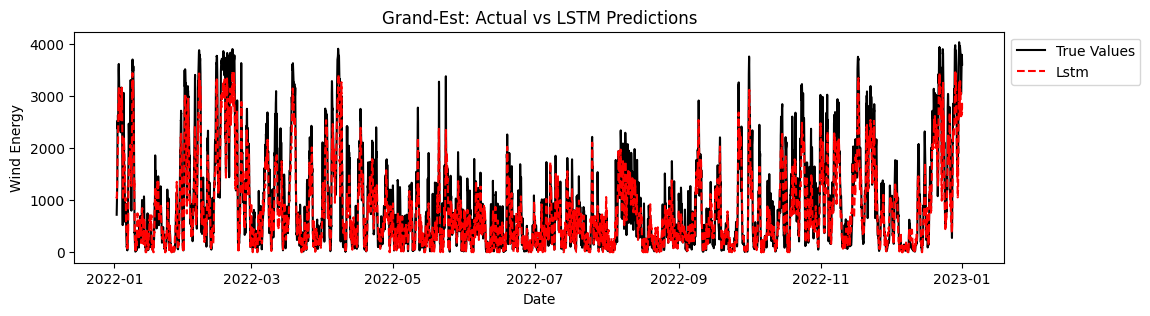

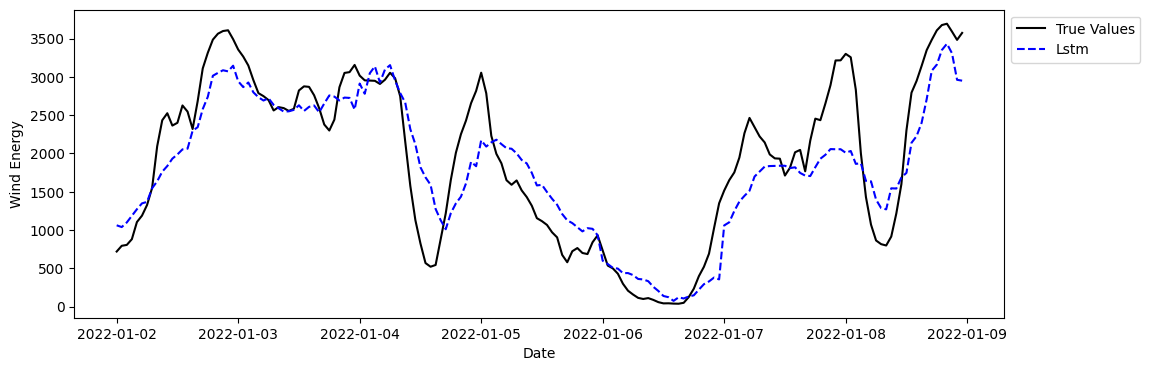

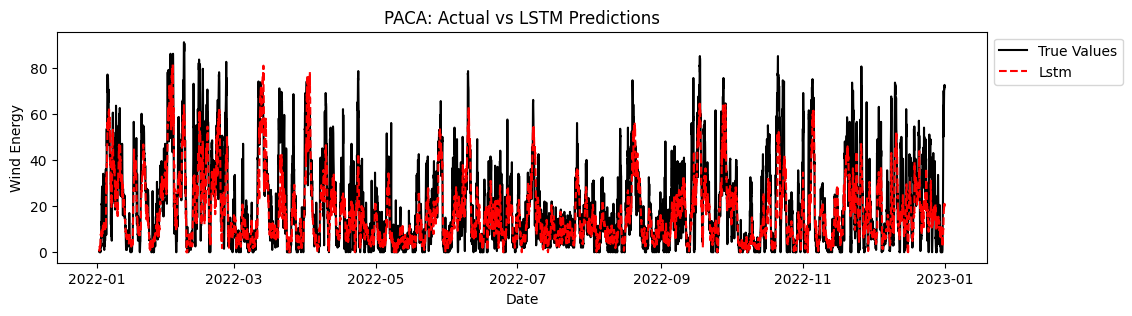

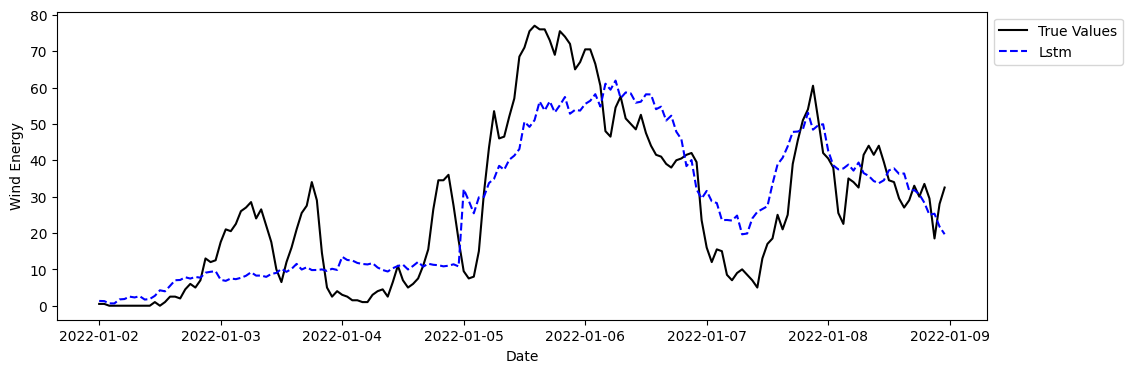

In [ ]:
regions__ = ['Grand-Est', 'PACA']
model='lstm'
for region in regions__:
    evaluate_plot(lstm_results[region]['y_true'], lstm_results[region][f'y_pred_cnn_gru'], model.capitalize(), region, 'wind')


In [2]:
# load data
df_results = pd.read_csv('results/df_results_wind_all.csv')
df_results

,Unnamed: 0,Region,Model,MAE,RMSE,NRMSE
0,0,Auvergne-Rhône-Alpes,Naive,104.987580,138.553091,0.843291
1,1,Bourgogne-Franche-Comté,Naive,165.044128,227.067873,0.990210
2,2,Pays-de-la-Loire,Naive,213.322344,306.536836,0.926642
3,3,Bretagne,Naive,160.591518,234.261886,1.011365
4,4,Centre-Val de Loire,Naive,227.402301,321.403498,1.001214
5,5,Grand-Est,Naive,695.096841,979.840604,1.040667
6,6,Hauts-de-France,Naive,853.573260,1226.900638,0.994333
7,7,Ile-de-France,Naive,27.694712,38.479850,1.045578
8,8,Normandie,Naive,139.538519,202.788474,0.967642
9,9,Nouvelle-Aquitaine,Naive,226.914206,312.193866,0.932143


In [3]:
# Create a name mapping dictionary
name_mapping = {
    "Auvergne-Rhône-Alpes": "Auvergne-Rhône-Alpes",
    "Bourgogne-Franche-Comté": "Bourgogne-Franche-Comté",
    "Bretagne": "Bretagne",
    "Centre-Val-de-Loire": "Centre-Val de Loire",
    "Corse": "Corse",
    "Grand-Est": "Grand Est",
    "Hauts-de-France": "Hauts-de-France",
    "Ile-de-France": "Île-de-France",
    "Normandie": "Normandie",
    "Nouvelle-Aquitaine": "Nouvelle-Aquitaine",
    "Occitanie": "Occitanie",
    "Pays-de-la-Loire": "Pays de la Loire",
    "PACA": "Provence-Alpes-Côte d'Azur",
    "Guadeloupe": "Guadeloupe",
    "Martinique": "Martinique",
    "Guyane": "Guyane",
    "La Réunion": "La Réunion",
    "Mayotte": "Mayotte"
}

df_chloropleth = df_results.copy()
df_chloropleth['Region'] = df_chloropleth["Region"].replace(name_mapping)
df_chloropleth = df_chloropleth[['Region', 'Model', 'NRMSE']]

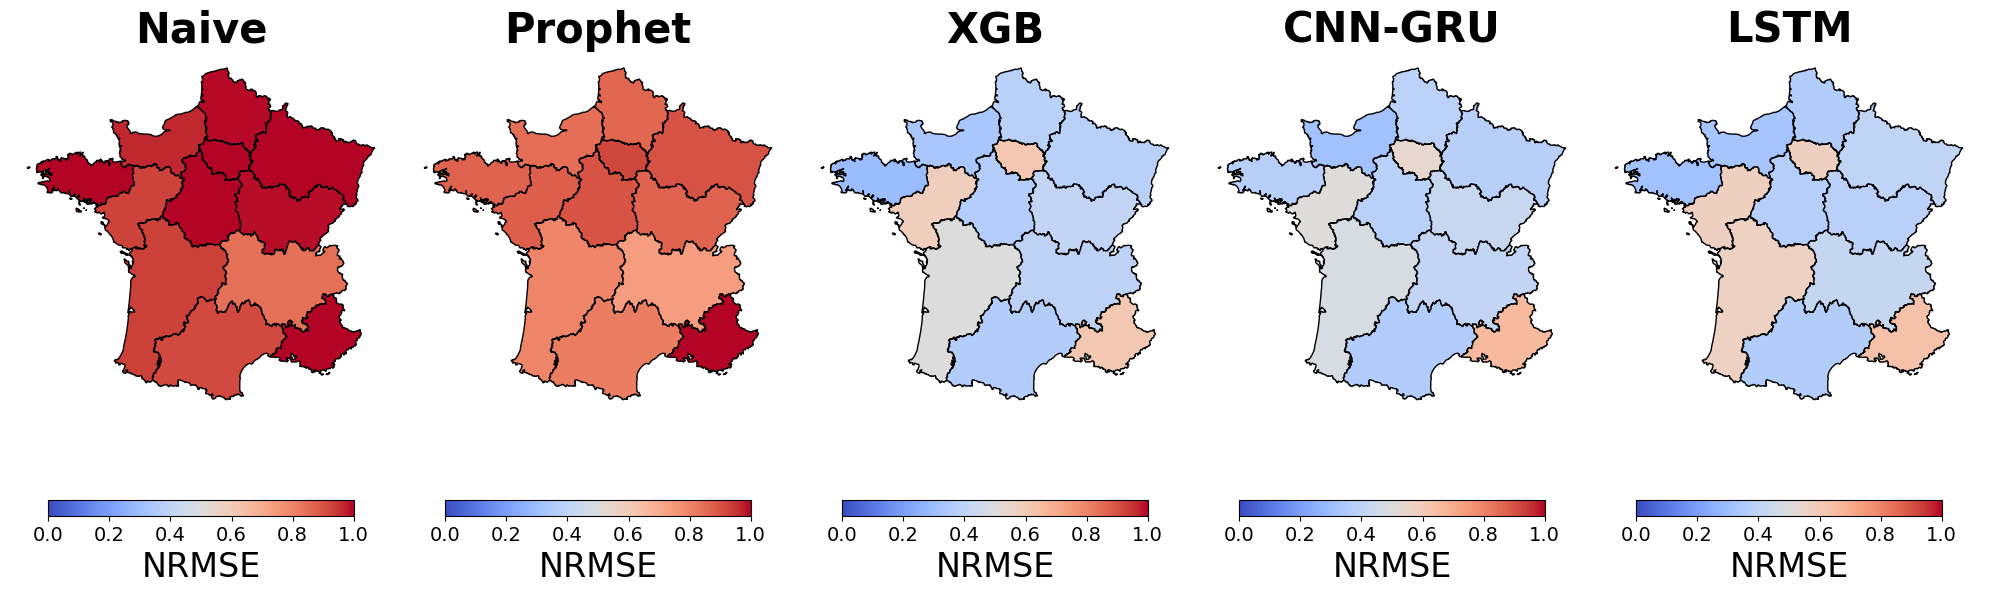

In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import font_manager

geojson_url = "data/france_regions.geojson"
gdf = gpd.read_file(geojson_url)
gdf = gdf.merge(df_chloropleth, how='left', left_on='nom', right_on='Region')

# Only keep matched regions
gdf_filtered = gdf[gdf['Region'].notna()].copy()
models = gdf_filtered.Model.unique()

fig, ax = plt.subplots(1, 5, figsize=(20, 6)) 
for i, c_model in enumerate(models):
    gdf_filtered_model = gdf_filtered[gdf_filtered['Model'] == c_model]

    plot = gdf_filtered_model.plot(
        column='NRMSE',
        ax=ax[i],
        legend=True,
        cmap='coolwarm',
        edgecolor='black',
        linewidth=1,
        vmin=0, vmax=1,
        legend_kwds={
            'label': f"NRMSE",
            'orientation': "horizontal", 'shrink':0.8
        }
    )
    ax[i].set_title(c_model, size=30, fontweight='bold')
    ax[i].set_axis_off()
    cbar = plot.get_figure().axes[-1]  # This gets the colorbar axis
    cbar.tick_params(labelsize=14)     # Set tick label size
    cbar.set_xlabel(cbar.get_xlabel(), fontsize=24) 

plt.tight_layout()
plt.show()

fig.savefig(f'figures/wind_error_map.pdf', transparent=True)


Hourly wind analysis

In [19]:
records2 = []
model_keys = {
    'Naive': 'y_pred_naive',
    'Prophet': 'y_pred_prophet',
    'XGB': 'y_pred_xgb',
    'CNN-GRU': 'y_pred_cnn_gru',
    'LSTM': 'y_pred_lstm'
}

# Get list of all regions from any model (assume all models cover same regions)
regions = next(iter(all_results.values())).keys()

for region_name in regions:
    # Get y_true from any model (assume all models share the same y_true per region)
    y_true = all_results['Naive'][region_name]['y_true']
    datetime_index = y_true.index

    for i in range(len(y_true)):
        record = {
            'datetime': datetime_index[i],
            'Region': region_name,
            'y_true': y_true.iloc[i] if isinstance(y_true, pd.Series) else y_true[i]
        }

        for model_name, pred_key in model_keys.items():
            y_pred = all_results[model_name][region_name][pred_key]
            record[pred_key] = y_pred.iloc[i] if isinstance(y_pred, pd.Series) else y_pred[i]
        
        records2.append(record)

# Create the final DataFrame
df_all_predictions = pd.DataFrame(records2)
df_all_predictions['datetime'] = pd.to_datetime(df_all_predictions['datetime'])
df_all_predictions.set_index('datetime', inplace=True)
df_all_predictions['hour'] = df_all_predictions.index.hour
df_all_predictions['month'] = df_all_predictions.index.month

In [ ]:
df_all_predictions.columns

Index(['Region', 'y_true', 'y_pred_naive', 'y_pred_prophet', 'y_pred_xgb',
       'y_pred_cnn_gru', 'y_pred_lstm', 'hour', 'month'],
      dtype='object')

In [1]:
df_all_predictions.to_csv('results/wind_hourly_analysis_df.csv')

NameError: name 'df_all_predictions' is not defined

Diebold Mariano Test

In [3]:
from dieboldmariano import dm_test
import pandas as pd

In [4]:
df_hourly_analysis = pd.read_csv('results/wind_hourly_analysis_df.csv')
df_hourly_analysis_selected = df_hourly_analysis[df_hourly_analysis['Region'].isin(['Grand-Est', 'PACA'])]
df_hourly_analysis_selected

,datetime,Region,y_true,y_pred_naive,y_pred_prophet,y_pred_xgb,y_pred_cnn_gru,y_pred_lstm,hour,month
43680,2022-01-02 00:00:00,Grand-Est,718.5,360.5,909.228232,693.719060,732.214700,1110.311000,0,1
43681,2022-01-02 01:00:00,Grand-Est,793.5,235.5,878.291243,694.580700,817.155000,1084.927400,1,1
43682,2022-01-02 02:00:00,Grand-Est,805.0,137.0,855.434393,620.002400,891.905460,1136.701900,2,1
43683,2022-01-02 03:00:00,Grand-Est,880.0,122.0,838.459968,723.151550,1053.388800,1164.882900,3,1
43684,2022-01-02 04:00:00,Grand-Est,1104.0,173.0,807.641720,641.250550,1092.147700,1161.586400,4,1
...,...,...,...,...,...,...,...,...,...,...
104827,2022-12-31 19:00:00,PACA,70.5,0.0,39.998662,13.618690,13.481443,17.475685,19,12
104828,2022-12-31 20:00:00,PACA,70.5,0.0,40.040634,20.054910,9.981748,16.333063,20,12
104829,2022-12-31 21:00:00,PACA,72.5,0.0,39.444153,26.345898,11.155777,16.276870,21,12
104830,2022-12-31 22:00:00,PACA,72.5,0.0,39.662616,18.279818,13.158814,17.333048,22,12


In [6]:
df_hourly_analysis_selected.to_csv('results/df_wind_dm_test.csv')

challenger: y_pred_prophet


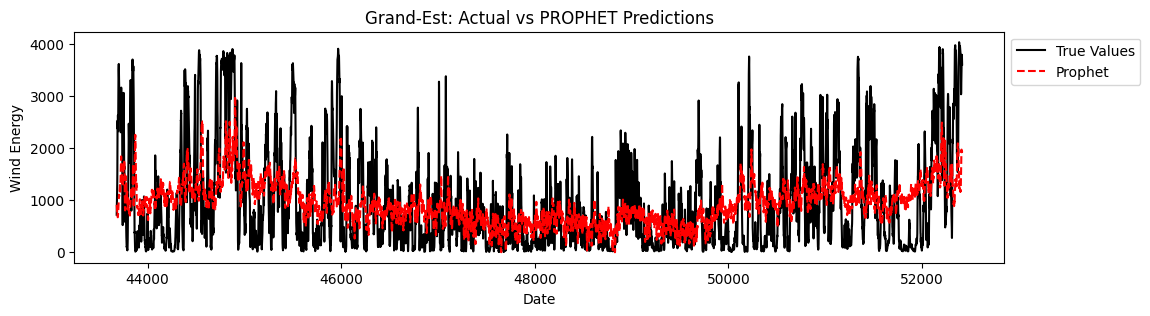

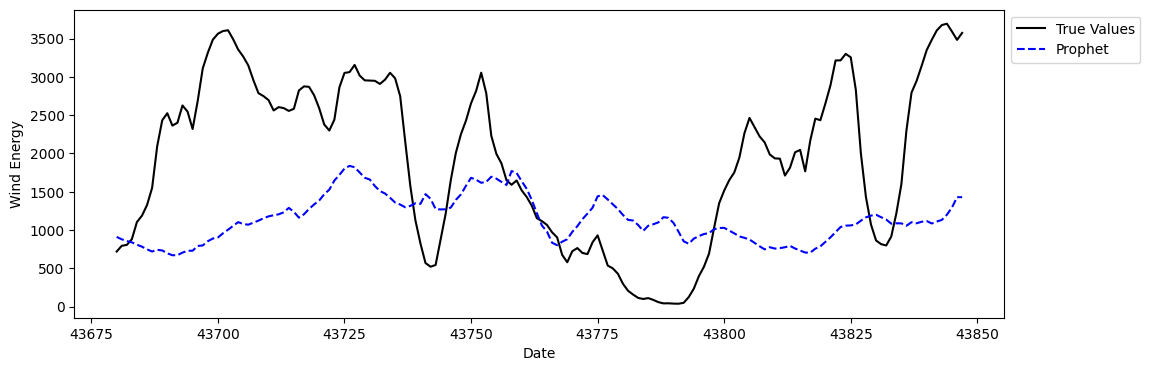

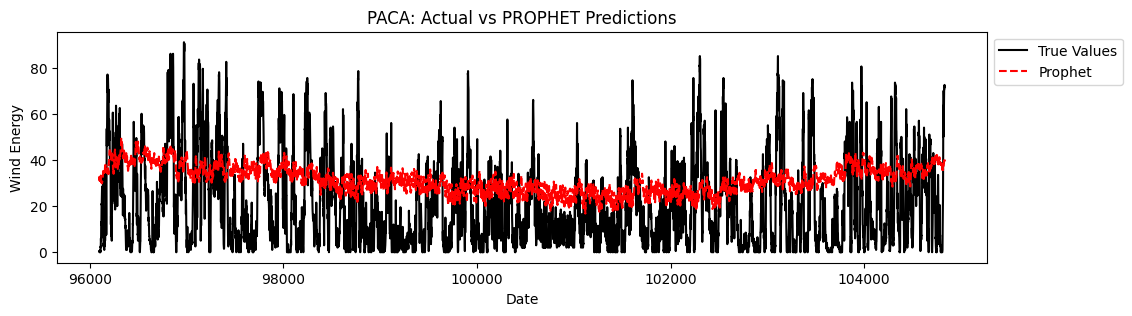

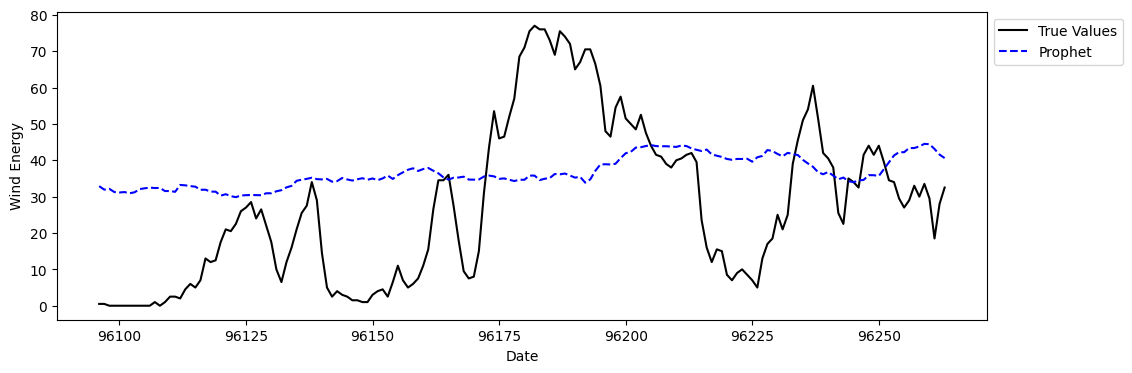

,Region,Model,dm_statistic,p_value
0,Grand-Est,y_pred_naive,16.277035,1.0
1,Grand-Est,y_pred_xgb,-52.227649,0.0
2,Grand-Est,y_pred_cnn_gru,-50.562637,0.0
3,Grand-Est,y_pred_lstm,-50.616162,0.0
4,PACA,y_pred_naive,6.110040,1.0
5,PACA,y_pred_xgb,-57.988425,0.0
6,PACA,y_pred_cnn_gru,-52.535692,0.0
7,PACA,y_pred_lstm,-56.593777,0.0


In [10]:
challenger = 'y_pred_prophet'
model_cols = [col for col in df_hourly_analysis_selected.columns if col.startswith('y_pred_') and col != challenger]
dm_results = []

print(f'challenger: {challenger}')
for region, region_data in df_hourly_analysis_selected.groupby('Region'):
    y_true = region_data['y_true']
    y_pred_challenger = region_data[challenger]
    evaluate_plot(y_true, y_pred_challenger, 'prophet', region, 'wind')
    for pred in model_cols:
        y_pred = region_data[pred].values

        dm_statistic, p_value = dm_test(y_true, y_pred, y_pred_challenger, one_sided=True) # test if model is significanlty better.
        dm_results.append({
            'Region': region,
            'Model': pred,
            'dm_statistic': dm_statistic,
            'p_value': p_value
        })
dm_results = pd.DataFrame(dm_results)
dm_results

In [ ]:
print(dm_results.to_latex(index=False, float_format='%0.2f'))

HOURLY AND MONTHLY ANALYSIS

In [4]:
model_keys = {
    'Naive': 'y_pred_naive',
    'Prophet': 'y_pred_prophet',
    'XGB': 'y_pred_xgb',
    'CNN-GRU': 'y_pred_cnn_gru',
    'LSTM': 'y_pred_lstm'
}
hourly_metrics = []

for model, model_pred in model_keys.items():
    hourly_df = df_hourly_analysis.groupby(['Region', 'hour']).apply(
        lambda x: pd.Series({
            'MAE': mean_absolute_error(x[model_pred], x['y_true'])
        })
    ).reset_index()
    hourly_df['model'] = model
    hourly_metrics.append(hourly_df)

df_hourly_analysis = pd.concat(hourly_metrics)
df_hourly_analysis

C:\Users\melan\AppData\Local\Temp\ipykernel_7748\68316849.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hourly_df = df_hourly_analysis.groupby(['Region', 'hour']).apply(
C:\Users\melan\AppData\Local\Temp\ipykernel_7748\68316849.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hourly_df = df_hourly_analysis.groupby(['Region', 'hour']).apply(
C:\Users\melan\AppData\Local\Temp\ipykernel_7748\6831684

,Region,hour,MAE,model
0,Auvergne-Rhône-Alpes,0,104.270604,Naive
1,Auvergne-Rhône-Alpes,1,103.340659,Naive
2,Auvergne-Rhône-Alpes,2,101.730769,Naive
3,Auvergne-Rhône-Alpes,3,100.773352,Naive
4,Auvergne-Rhône-Alpes,4,101.179945,Naive
...,...,...,...,...
283,Pays-de-la-Loire,19,128.551895,LSTM
284,Pays-de-la-Loire,20,123.242838,LSTM
285,Pays-de-la-Loire,21,126.854733,LSTM
286,Pays-de-la-Loire,22,137.440828,LSTM


<Axes: xlabel='hour', ylabel='MAE'>

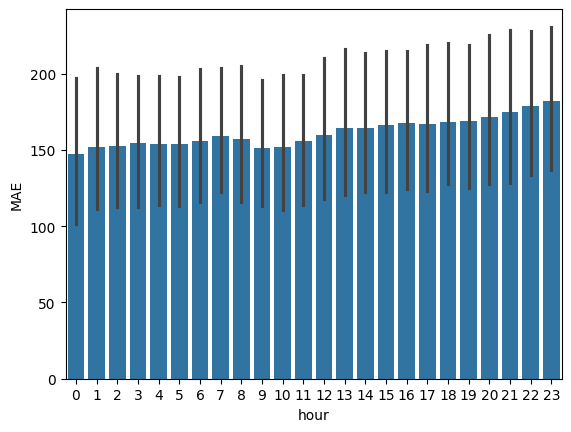

In [21]:
plt.Figure(figsize=(10,6))
sns.barplot(data=df_hourly_analysis, x ='hour', y = 'MAE')

In [6]:
regions=['Grand-Est', 'PACA']

In [28]:
# Sample original coolwarm
coolwarm = plt.cm.coolwarm(np.linspace(0, 1, 5))

# Identify the middle index
mid_idx = len(coolwarm) // 2

# Darken the middle color by reducing RGB (leave alpha untouched)
coolwarm[mid_idx, :3] *= 0.6  # Scale RGB channels to make it darker
coolwarm = np.clip(coolwarm, 0, 1)
coolwarm

array([[0.2298057 , 0.29871797, 0.75368315, 1.        ],
       [0.55431187, 0.69009701, 0.99551555, 1.        ],
       [0.52045658, 0.51862596, 0.51756148, 1.        ],
       [0.95665321, 0.59803382, 0.47730229, 1.        ],
       [0.70567316, 0.01555616, 0.15023281, 1.        ]])

C:\Users\melan\AppData\Local\Temp\ipykernel_7748\1884738208.py:8: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.lineplot(data=region_data, x='hour', y='MAE', hue='model',
C:\Users\melan\AppData\Local\Temp\ipykernel_7748\1884738208.py:8: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.lineplot(data=region_data, x='hour', y='MAE', hue='model',


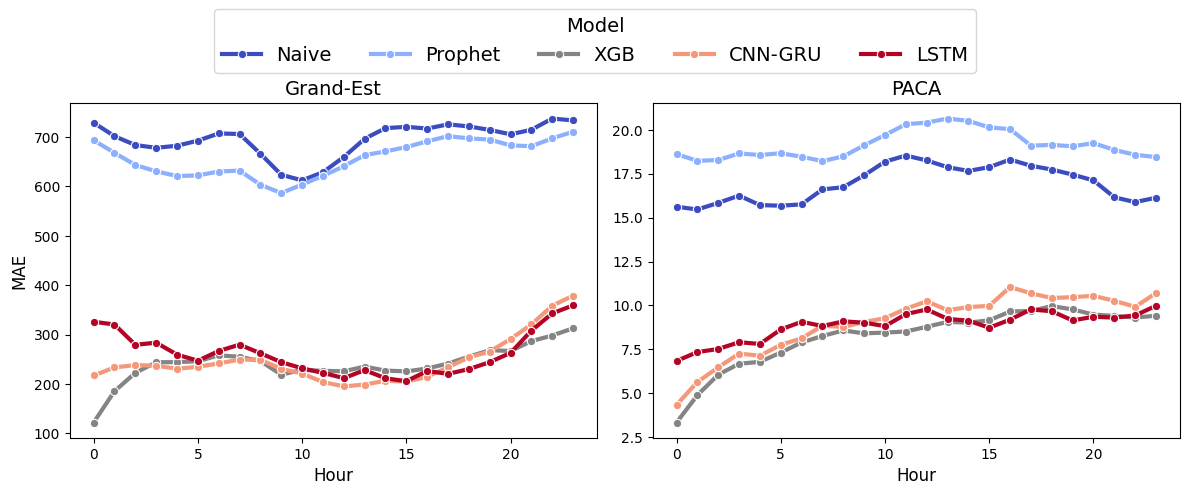

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

for i, region in enumerate(regions):
    region_data = df_hourly_analysis[df_hourly_analysis['Region'] == region]
    sns.lineplot(data=region_data, x='hour', y='MAE', hue='model', 
                 palette=coolwarm, ax=axes[i], linewidth=3, marker='o')
    
    axes[i].set_title(region, fontsize=14)
    axes[i].set_xlabel('Hour', fontsize=12)
    axes[i].set_ylabel('MAE', fontsize=12 if i == 0 else 0)
    if i != 0:
        axes[i].set_ylabel('')
    axes[i].legend_.remove()

# Only one legend, outside the plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Model', 
           fontsize=14, title_fontsize=14, loc='upper center', ncol=len(labels))
plt.tight_layout(rect=[0, 0, 1, 0.87])  # Leave space for legend

fig.savefig(f'figures/wind_hourly_plot.pdf')

plt.show()


In [2]:
import pandas as pd

# Example model performance: average MAE per model across all regions
data = {
    'Model': ['Naive (t-24)', 'Prophet', 'XGB', 'CNN-GRU', 'LSTM'],
    'RMSE_wind': [361.576, 317.008, 146.741, 145.807, 148.394],
    'RMSE_solar': [97.544, 128.123, 89.938, 89.303, 78.182]
}

df_perf = pd.DataFrame(data)


C:\Users\melan\AppData\Local\Temp\ipykernel_22272\2424445844.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_perf_sorted, x='RMSE_wind', y='Model', palette='coolwarm')


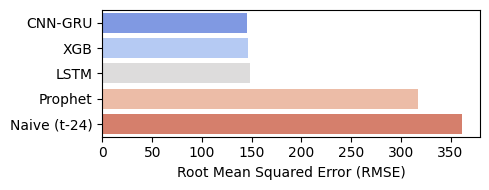

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort models by performance (lower MAE is better)
df_perf_sorted = df_perf.sort_values(by='RMSE_wind', ascending=True)

plt.figure(figsize=(5, 2))
sns.barplot(data=df_perf_sorted, x='RMSE_wind', y='Model', palette='coolwarm')

#plt.title('Average RMSE Across All Regions by Model', fontsize=14)
plt.xlabel('Root Mean Squared Error (RMSE)')
plt.ylabel('')
plt.tight_layout()
plt.savefig('figures/wind_ranking.pdf')
plt.show()


C:\Users\melan\AppData\Local\Temp\ipykernel_22272\3310646631.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_perf_sorted, x='RMSE_solar', y='Model', palette='coolwarm')


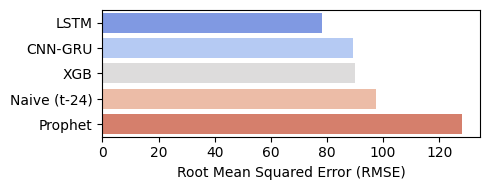

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort models by performance (lower MAE is better)
df_perf_sorted = df_perf.sort_values(by='RMSE_solar', ascending=True)

plt.figure(figsize=(5, 2))
sns.barplot(data=df_perf_sorted, x='RMSE_solar', y='Model', palette='coolwarm')

#plt.title('Average RMSE Across All Regions by Model', fontsize=14)
plt.xlabel('Root Mean Squared Error (RMSE)')
plt.ylabel('')
plt.tight_layout()
plt.savefig('figures/solar_ranking.pdf')
plt.show()
